In [339]:
import numpy as np 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from summarytools import dfSummary
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

### GitHub

GitHub link: 

**Kaggle Dataset**: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

**Kaggle Dataset Title**: *Histopathologic Cancer Detection*

B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection


## Machine Learning 3: CNN Tumor Detection

### Step 1: Brief description of the pporblem and data:

**Description of project**: The purpose of this analysis is to develop a CNN deep learning model that can predict whether the center of a 32x32px region of a patch contains at least one pixel of tumor tissue.

**Desciption of size, dimension, structure of data**: The data has a total of 220,025 samples. The dimensions of each image sample of the data is 96X96px in .tif format / **structure**. The accompanying `train_labels.csv` contains a 1 whether there is tumor tissue and 0 whether there is no tumor tissue based on image ids.

In [200]:
# load data
df_train = "data/train"
df_labels = pd.read_csv("data/train_labels.csv")
df_test = "data/test"
df_sample = pd.read_csv("data/sample_submission.csv")

In [201]:
df_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [202]:
df_labels.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [203]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


### Step 2: Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data

I visualized the data via a histogram and pie chart to understand whether the data is imbalanced. Overall the dataset is moderately balanced. We have ~60% of images without tumor tissue and 40% with tumor tissue. Additionally, I have chosen 10 randomly selected images with tumor tissue and 10 randomly selected images without tumor tissue to get a sense of how the data looks. Each image has an id associated with its filename. Based on the Data Frame Summary we can see we don't have any missing values. Therefore, we don't need to treat for it. However, we do need to pre-process the images leveraging tensforflow's `ImageDataGenerator` to ready it for the model step.

In [204]:
dfSummary(df_labels)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id[object],1. f38a6374c348f90b587e046aac60792. 33e170e24f1455a38e331ae45185ed3. bd933b010960ffb209cf49b70a107a4. 787b356e4baa34b7a91394fdf8c97f5. 16f255bbb6177df95469f25bc666c16. e1782744e9ec22d36028602af0881e7. db2e2875d34e5d471f50594a0ef01b8. d9a75fcff911931dc393413e96e83e9. 1c1d8ca357e09f5a0045cf8385805610. 47b7c9be06b155094ea6eb085d4e5a11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)220,015 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,label[int64],1. 02. 1,"130,908 (59.5%)89,117 (40.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABM0lEQVR4nO3bwWnDQBRF0T9BmHgzgxC4GBWRYlPEdCOEZhEbbyaL9PA+5N1Twbe5CGz0ypwzAIUSEfeIuGUfYuQ953xmH5Fh2bbtq9a6Zh/iYoxxllK+HYNbaq3rvu/P1tor+5j/7rquz977ehzHLSL8YouIaK29Ho/HT/YxJu7ZB2T5yD4APogNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJBZIv5e6ss+xIH797yMMc7e+xrGL/UpjTHOiHhn35GBwYue7eClMOWDivuTzfYpk8F6yuc8q8tgO+Vzn9VlcJ/y8QtciD91IUNskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoOM7ZTP8TNns57yOc/qMjB4YX8g8wsKW2rfwuH0SAAAAABJRU5ErkJggg=="">",0(0.0%)


([<matplotlib.patches.Wedge at 0x19dc62710>,
 [Text(-1.051404079333815, -0.3233410922852414, '0'),
  Text(1.0514041096071884, 0.32334099384568554, '1')],
 [Text(-0.5734931341820808, -0.17636786851922254, '59.5%'),
  Text(0.57349315069483, 0.17636781482491937, '40.5%')])

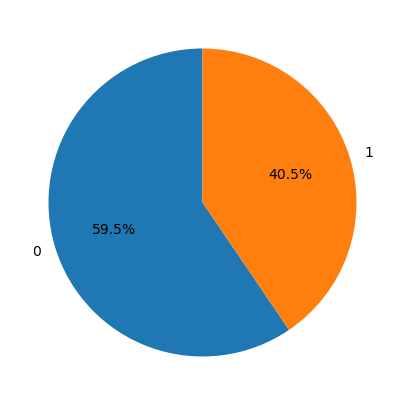

In [205]:
plt.figure(figsize=(5,5))
plt.pie(df_labels.label.value_counts().values, labels=df_labels['label'].unique(), autopct='%1.1f%%', startangle = 90)

<Axes: xlabel='label', ylabel='count'>

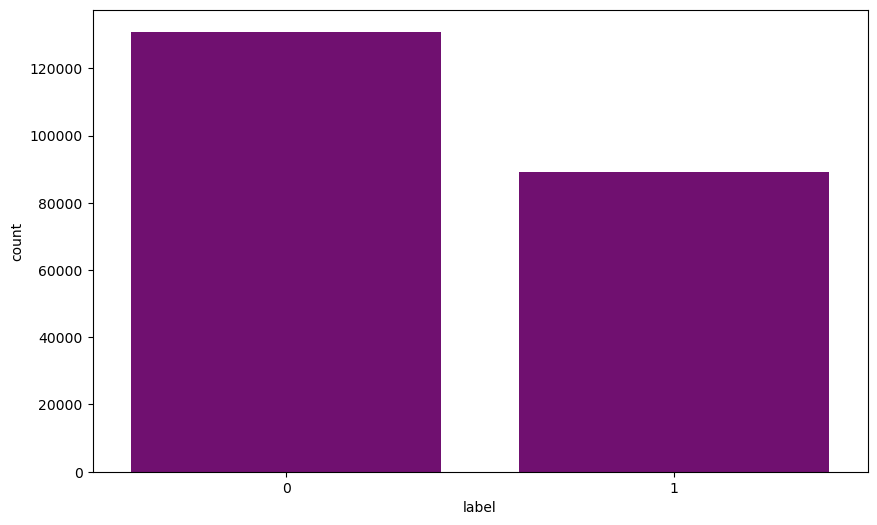

In [206]:
plt.figure(figsize=(10,6))
sns.countplot(x=df_labels.label, color = 'purple')

In [207]:
not_tumors = []
for each_not_tumor in df_labels[df_labels['label'] == 0]['id'].sample(n=5).values:
    not_tumors.append(Image.open(os.path.join(df_train, str(each_not_tumor) + '.tif') ))

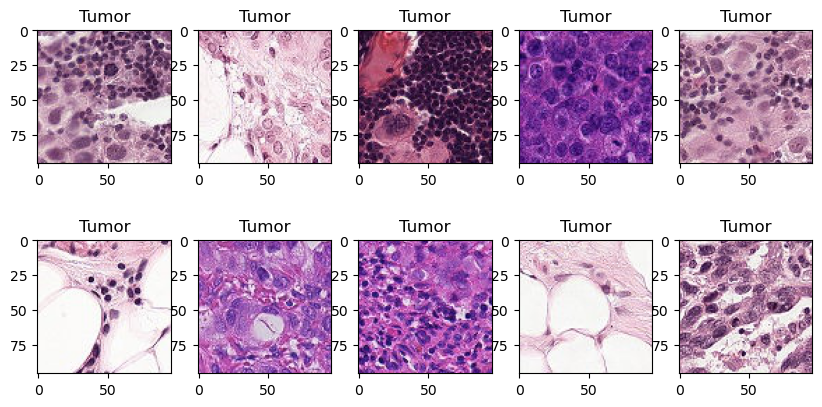

In [208]:
n = 10

tumors = []
for each_tumor in df_labels[df_labels['label'] == 1]['id'].sample(n=n).values:
    tumors.append(Image.open(os.path.join(df_train, str(each_tumor) + '.tif')  ))

plt.figure(figsize=(10, 5))
for i, img in enumerate(tumors):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title('Tumor')
plt.show()

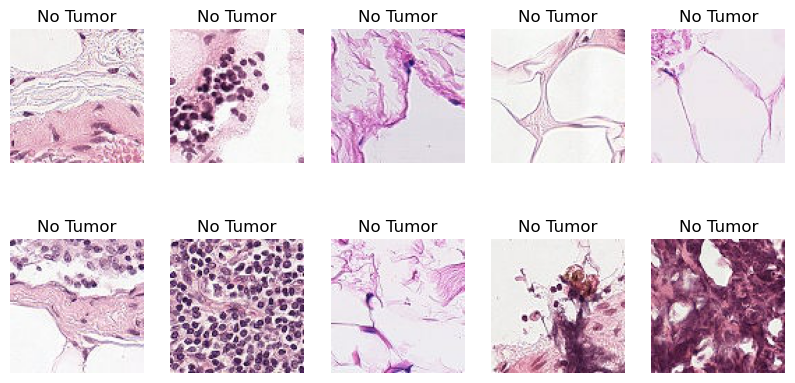

In [209]:
n = 10

not_tumors = []
for each_not_tumor in df_labels[df_labels['label'] == 0]['id'].sample(n=n).values:
    not_tumors.append(Image.open(os.path.join(df_train, str(each_not_tumor) + '.tif') ))
    
plt.figure(figsize=(10, 5))
for i, img in enumerate(not_tumors):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title('No Tumor')
    plt.axis('off')
plt.show()

### Data Preprocessing
I will utilize Keras to produce a CNN deep learning model for this dataset. However, to utilize the data in Keras we must first preprocess it leveraging the `flow_from_directory` function. However, before we jump into that, I had this idea of first reducing the size of each image from 96x96px to 38x38px. The reason for this is the tumor cells are located in the center patch of each image within the 32x32px region. I thought it would be more computationally efficient if we zoned in on this section. The reason I did not go with 32x32px is because CNN feature selection will remove a pixels as it scans through the image if we don't consider padding. Knowing in advance I want to start off with 3 CNN layers, this will effectively get me to 32x32px on the third CNN layer. I have created a crop function to help me crop each of the images. I pass this through the initialization of `ImageDataGenerator` through the `preprocessing_function`. In addition, I rescale the data (i.e., 1/255) and split the data between training and validation at 80/20, respectively.

After the `ImageDataGenerator` is initialized, I create a training and validation generator. Now the data is ready for the model step.

In [210]:
# images are 96 x 96px
img_height, img_width = 96, 96

# helper function to crop 38x38px img from the original 96x96px
def crop(img):
    # center of x and y coordinates of the original img
    ctr_x, ctr_y = img.shape[1] // 2, img.shape[0] // 2
    # to get 38px we need to offset center by half (38/2 = 19)
    crop_x = ctr_x - 19
    # to get 38px we need to offset center by half (38/2 = 19)
    crop_y = ctr_y - 19
    # return cropped img
    return img[crop_x:crop_x + 38, crop_y:crop_y + 38]

In [211]:
# was getting an error about label should be string format so i ran below
df_labels["id"] = df_labels["id"]+".tif"
df_labels['label'] = df_labels['label'].astype(str)

In [212]:
#initialize data generator
data_generator = ImageDataGenerator(preprocessing_function=crop,
                                    rescale=1/255,
                                    validation_split = 0.2)

In [213]:
# training generator
training_generator = data_generator.flow_from_dataframe(dataframe=df_labels,
                                                        directory=df_train,
                                                        x_col="id",
                                                        y_col="label",
                                                        target_size=(38,38),
                                                        class_mode="binary",
                                                        batch_size=128,
                                                        subset="training",
                                                        seed=42,
                                                        shuffle=True)

# validation generator
validation_generator = data_generator.flow_from_dataframe(dataframe=df_labels,
                                                          directory=df_train,
                                                          x_col="id",
                                                          y_col="label",
                                                          target_size=(38,38),
                                                          class_mode="binary",
                                                          batch_size=128,
                                                          subset="validation",
                                                          seed=42,
                                                          shuffle=True)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Step 3: DModel Architecture:

**Base model**:
The first model is our base. I initiate 3 convlusion layers and in between each layer I do maxpooling. After the CNN layers I flatten them and pass the features through a dense layer all of which are activated via `relu`. The final output layer utilizes sigmoid as its activation for this classification problem.

**Hyperparameter tuned model**:
Extending the base model to include hyperparameter tuning, I incorporated average pooling on the third CNN layer. My thought was the deeper the layers the more details the model will see. I wanted to smooth out those details with the average pooling method. In addition, between each CNN layer, I have added batch normalization and an l2 regularizer to reduce the change of overfitting and ensuring the model generalizes better with new data. As another hyperparameter I included a dropout layer. Finally, I wrapped the model up with a 0.001 learning rate leveraging the adam optimizer.

**Hyperparameter balanced tuned model**:
Noting from our EDA step that the data is moderately balanced at 60 / 40. I wanted to see whether adding weights to the minority class would help with the model's performance when comparing each of the models. I kept the same tuned model discussed previously, however, I added class weights to treat for data imbalance.

### Base model

In [214]:
# CNN model architecture
base_model = models.Sequential([
    # convolution layer 1 with max pooling
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(38, 38, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # convolution layer 2 with max pooling
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # convolution layer 3 with max pooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # base model using sigmoid for binary classification task
    layers.Dense(1, activation='sigmoid')
])

# compile model with AUC metric as per competition requirements
base_model.compile(loss='binary_crossentropy', metrics=['accuracy', AUC()])

# print model summary
base_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 36, 36, 16)        448       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 18, 18, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 6, 6, 64)          18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 3, 3, 64)         

In [215]:
# train the CNN deep learning base model compiled above with no hyperparameter tuning
# and no optimizer initated (i.e., adam)
history_base = base_model.fit(
    training_generator,
    # set validation data
    validation_data=validation_generator,
    # evaluate after 5 epochs whether model is improving in accuracy
    epochs=5,
    # set steps per epoch by taking the number of training samples generated
    # and dividing by batch size
    steps_per_epoch=training_generator.samples // training_generator.batch_size,
    # set validation steps by taking the number of validation samples generated
    # and dividing by batch size
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/5
1375/1375 [==============================] - 105s 76ms/step - loss: 0.4786 - accuracy: 0.7762 - auc_5: 0.8437 - val_loss: 0.4295 - val_accuracy: 0.8089 - val_auc_5: 0.8825
Epoch 2/5
1375/1375 [==============================] - 103s 75ms/step - loss: 0.4214 - accuracy: 0.8105 - auc_5: 0.8821 - val_loss: 0.4110 - val_accuracy: 0.8159 - val_auc_5: 0.8948
Epoch 3/5
1375/1375 [==============================] - 102s 74ms/step - loss: 0.3990 - accuracy: 0.8209 - auc_5: 0.8950 - val_loss: 0.4206 - val_accuracy: 0.8094 - val_auc_5: 0.8966
Epoch 4/5
1375/1375 [==============================] - 101s 73ms/step - loss: 0.3815 - accuracy: 0.8307 - auc_5: 0.9046 - val_loss: 0.3893 - val_accuracy: 0.8256 - val_auc_5: 0.9117
Epoch 5/5
1375/1375 [==============================] - 102s 74ms/step - loss: 0.3663 - accuracy: 0.8386 - auc_5: 0.9124 - val_loss: 0.3719 - val_accuracy: 0.8356 - val_auc_5: 0.9171


### Tuned model

In [216]:
# CNN model architecture with hyperparameter tuning
tuned_model = models.Sequential([
    # convolution layer 1 with max pooling
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(38, 38, 3), kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # convolution layer 2 with max pooling
    layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # convolution layer 3 with max pooling
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l2(0.01)),
    layers.AveragePooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu',kernel_regularizer=l2(0.01)),
    # include Dropout hyperparametr to decrease liklihood of overfitting and to better generalize the model to new data
    layers.Dropout(0.1),
    # base model using sigmoid for binary classification task
    layers.Dense(1, activation='sigmoid')
])

# compile model with AUC metric as per competition requirements and include adam optimizer
tuned_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', AUC()])

# print model summary
tuned_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 36, 36, 16)        448       
                                                                 
 batch_normalization_8 (Bat  (None, 36, 36, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 18, 18, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_9 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                                
                                                      

In [219]:
# train the CNN deep learning base model compiled above with no hyperparameter tuning
# and no optimizer initated (i.e., adam)
history_tuned = tuned_model.fit(
    training_generator,
    # set validation data
    validation_data=validation_generator,
    # evaluate after 5 epochs whether model is improving in accuracy
    epochs=5,
    # set steps per epoch by taking the number of training samples generated
    # and dividing by batch size
    steps_per_epoch=training_generator.samples // training_generator.batch_size,
    # set validation steps by taking the number of validation samples generated
    # and dividing by batch size
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/5
1375/1375 [==============================] - 126s 91ms/step - loss: 0.3697 - accuracy: 0.8540 - auc_6: 0.9254 - val_loss: 0.5075 - val_accuracy: 0.7855 - val_auc_6: 0.8572
Epoch 2/5
1375/1375 [==============================] - 108s 79ms/step - loss: 0.3638 - accuracy: 0.8575 - auc_6: 0.9282 - val_loss: 0.6535 - val_accuracy: 0.7195 - val_auc_6: 0.9014
Epoch 3/5
1375/1375 [==============================] - 108s 78ms/step - loss: 0.3614 - accuracy: 0.8586 - auc_6: 0.9295 - val_loss: 0.4242 - val_accuracy: 0.8323 - val_auc_6: 0.9094
Epoch 4/5
1375/1375 [==============================] - 109s 79ms/step - loss: 0.3585 - accuracy: 0.8603 - auc_6: 0.9308 - val_loss: 0.6832 - val_accuracy: 0.7237 - val_auc_6: 0.8698
Epoch 5/5
1375/1375 [==============================] - 108s 78ms/step - loss: 0.3522 - accuracy: 0.8645 - auc_6: 0.9336 - val_loss: 0.4524 - val_accuracy: 0.8371 - val_auc_6: 0.9039


### Tuned balanced model

In [235]:
# image directory
img_dir = "data/train"

# initialize empty list to store cropped imgs
cropped_imgs = []
# loop through each img by leveraging id from df_labels data
for each_img in df_labels['id']:
    img_path = os.path.join(img_dir, each_img)
    # load original 96x96px image
    img = load_img(img_path, target_size=(img_height, img_width))
    # convert to np array
    img_array = img_to_array(img)
    # crop img to 38x38px utilizing previously initialized helper function
    cropped_img = crop(img_array)
    cropped_imgs.append(cropped_img)

# convert cropped imgs to np array
X_train = np.array(cropped_imgs)

# get labels from previously assigned df_labels
y_train = df_labels['label'].values

# calculate class weights to treat for data imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# store class weights into dict
# initialize dict
class_weights_dict = {}
for each_weight in range(len(class_weights)):
    class_weights_dict[each_weight] = class_weights[each_weight]

In [248]:
# convert to int from np array str for model to work
y_train = y_train.astype(int)

In [249]:
# Now I can fit the previously tuned_model with the addition of class weights
history_tuned_balanced = tuned_model.fit(
    X_train,
    y_train,
    epochs=5,        
    batch_size=128,     
    class_weight=class_weights_dict, 
    validation_split=0.2, 
)

Epoch 1/5
1376/1376 [==============================] - 61s 44ms/step - loss: 0.4672 - accuracy: 0.8049 - auc_6: 0.8783 - val_loss: 0.9659 - val_accuracy: 0.6247 - val_auc_6: 0.8328
Epoch 2/5
1376/1376 [==============================] - 59s 43ms/step - loss: 0.4387 - accuracy: 0.8203 - auc_6: 0.8926 - val_loss: 0.4888 - val_accuracy: 0.7788 - val_auc_6: 0.8678
Epoch 3/5
1376/1376 [==============================] - 58s 42ms/step - loss: 0.4320 - accuracy: 0.8231 - auc_6: 0.8960 - val_loss: 0.5310 - val_accuracy: 0.7585 - val_auc_6: 0.8450
Epoch 4/5
1376/1376 [==============================] - 57s 42ms/step - loss: 0.4271 - accuracy: 0.8253 - auc_6: 0.8984 - val_loss: 2.6266 - val_accuracy: 0.5994 - val_auc_6: 0.4554
Epoch 5/5
1376/1376 [==============================] - 62s 45ms/step - loss: 0.4269 - accuracy: 0.8254 - auc_6: 0.8987 - val_loss: 0.5575 - val_accuracy: 0.7342 - val_auc_6: 0.8163


### Step 4: Results and Analysis:

After fitting each of the three models using different architectures and approaches, I have plotted results based on accuracy, loss, and AUC. Since the evaluation of the Kaggle competition is AUC this would be the focus. However, breifly, analyzing the results of the accuracy plots of training vs validation data, I can see that the base model, which is the simpler model, seemed to perform the best out of the three. In fact, note how the base model's valudation AUC and Train AUC increases with each epoch. Note also how the validation and train increase closely together. Similarily, note how train loss and validation loss decrease together. To me this is a signal that the model is performing well and is not overfitting.

Reviewing the same plots for tuned_model and tuned_balanced_model which both increase in complexity, I don't notice much imporvement in the AUC. However, I did notice sparodic behavior in each of the validation metrics - loss, accuracy, and AUC. This signals the model may be too complex and may be overfitting and struggling to generalize to new data.

Finally, I included a summary of results for validation AUC which is the measure of focus for this Kaggle competition. Based on the results, I will use the base model as my primary model. Additionally I uploaded the base model predictions against test data into Kaggle to see how well the models performed within the leaderboard. One aspect to note is, even though the base model performed better than the tuned models. I did some moderate preprocessing to get the base model to work well by cropping each of the images at the focal point of focus 38x38px.

Overall, the reason I beleieve the complex models did not work well is perhaps the architecture may have been overcomplicated for the cropped images.

In [258]:
def plot_accuracy(history, model_name):
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f" {model_name} Accuracy vs. epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def plot_loss(history,model_name):
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title(f" {model_name} Loss vs. epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def plot_auc(history, model_name):
    train_auc = history.history.get('auc_5') or history.history.get('auc_6')
    val_auc = history.history.get('val_auc_5') or history.history.get('val_auc_6')
    plt.plot(train_auc, label='Train AUC')
    plt.plot(val_auc, label='Validation AUC')
    plt.title(f" {model_name} AUC vs. epochs")
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

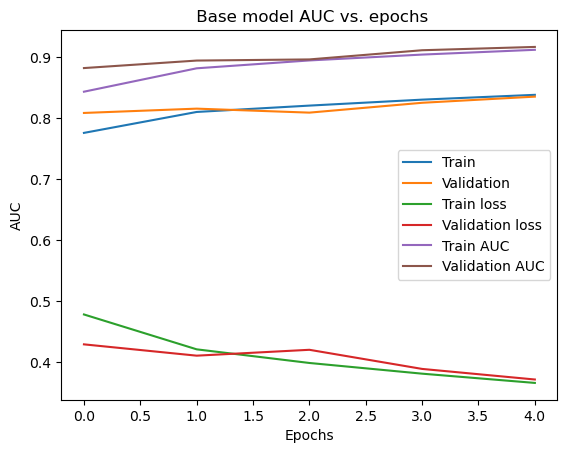

In [261]:
# plot base model
plot_accuracy(history_base,'Base model')
plot_loss(history_base,'Base model')
plot_auc(history_base,'Base model')

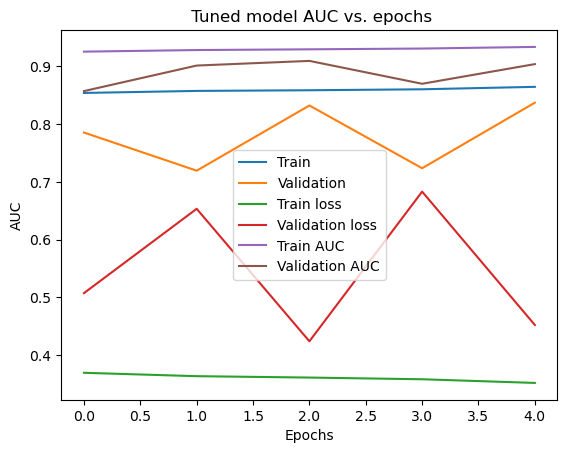

In [262]:
# plot tuned model
plot_accuracy(history_tuned,'Tuned model')
plot_loss(history_tuned,'Tuned model')
plot_auc(history_tuned,'Tuned model')

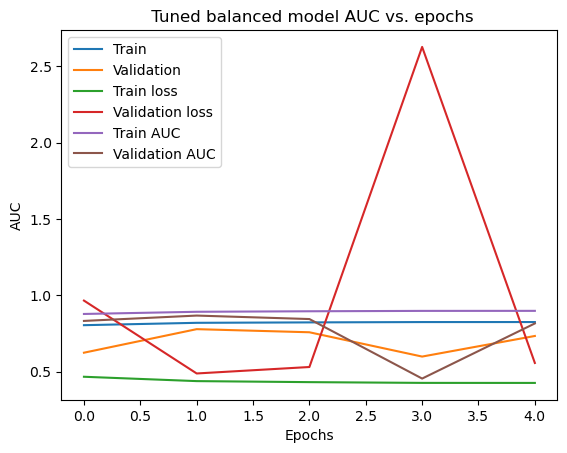

In [263]:
# plot tuned balanced model
plot_accuracy(history_tuned_balanced,'Tuned balanced model')
plot_loss(history_tuned_balanced,'Tuned balanced model')
plot_auc(history_tuned_balanced,'Tuned balanced model')

In [288]:
val_auc_base = history_base.history['val_auc_5']
val_auc_tuned = history_tuned.history['val_auc_6']
val_auc_balanced_tuned = history_tuned_balanced.history['val_auc_6']
Epochs = [1,2,3,4,5]

res = pd.DataFrame({
    'Epoch' : Epochs,
    'Validation AUC for base model': val_auc_base,
    'Validation AUC for tuned model': val_auc_tuned,
    'Validation AUC for tuned balanced model': val_auc_balanced_tuned
})


# print res without index with formatted headers in center
pd.set_option('display.colheader_justify', 'center') 
print(res.to_string(index=False))

 Epoch  Validation AUC for base model  Validation AUC for tuned model  Validation AUC for tuned balanced model
  1               0.882454                        0.857179                            0.832754                
  2               0.894754                        0.901364                            0.867770                
  3               0.896628                        0.909430                            0.845024                
  4               0.911679                        0.869840                            0.455399                
  5               0.917116                        0.903875                            0.816306                


### Submission test results

In [291]:
test_ids = []

for file in os.listdir(df_test):
    test_ids.append(file)

test_df = pd.DataFrame({'id':test_ids})
print(test_df.head())

                        id                     
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif
2  19709bec800f372d0b1d085da6933dd3ef108846.tif
3  7a34fc34523063f13f0617f7518a0330f6187bd3.tif
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif


In [327]:
#initialize data generator
data_generator = ImageDataGenerator(preprocessing_function=crop,
                                    rescale=1/255)

# test generator
test_generator = data_generator.flow_from_dataframe(dataframe=df_labels,
                                                          directory=df_train,
                                                          x_col="id",
                                                          y_col="label",
                                                          target_size=(38,38),
                                                          class_mode="binary",
                                                          batch_size=1,
                                                          seed=42,
                                                          shuffle = True)

Found 220025 validated image filenames belonging to 2 classes.


In [336]:
# prediction
pred_base = base_model.predict(test_generator)

220025/220025 [==============================] - 311s 1ms/step


In [337]:
# Assuming pred_tuned is your prediction array
unique_values, counts = np.unique(pred_tuned, return_counts=True)

# Print unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.11471778154373169, Count: 220025


In [338]:
# convert predictions into submission file without extention for each id and label as second column
threshold = 0.5

# initialize empty lists for ids and labels
ids_base = []
labels_base = []

# extract ids and create labels for base model and remove the .tif extention from each id
for i in range(len(test_ids)):
    # Remove the extension to get the ID
    id = test_ids[i].split('.')[0]
    ids_base.append(id)
    labels_base.append(int(pred_base[i,0] >= threshold))

# make df for each model's results
res_base = pd.DataFrame({'id': ids_base, 'label': labels_base})

# save each res df into .csv file for upload
res_base.to_csv('submission_base_model.csv', index=False)

### Kaggle Score
After uploading my results to Kaggle, the score I recieved was just under 0.50. Looks there my model is not generalizing well to the test data and more work needs to be done. In the sections that follow, I discuss next steps on way we can potentially improve.
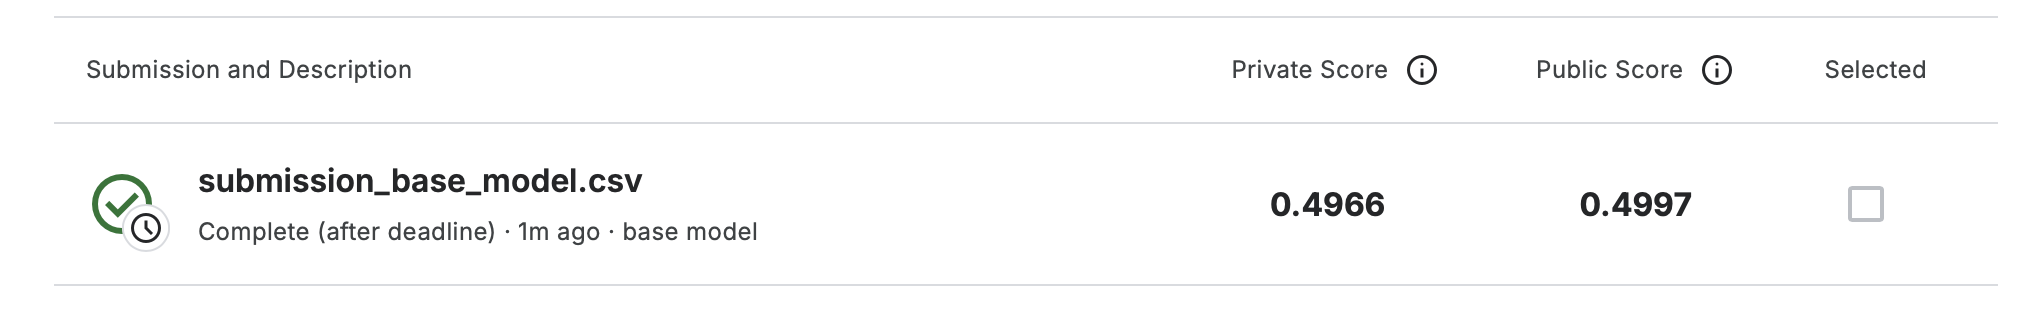

### Step 5: Conclusion

The interpretation of results were highlighted in the aforementioned **Results and Analysis** section. Breifly, the base model performed better than the more complex hyperparameter tuned and hyperparameter tuned balanced models. This may be because the model were overfitting the cropped images that I fed through the model. I initially thought smoothing out the ending CNN layer by using average pooling hyperparameter would produce better model performance and it did make the models run faster. However, the results were underwhelming when compared to the base model's results. I beleive batch normalization and dropout helped with the runtime of the model; however, it made decreased the generalization of the models.

To highlight some of the **learnings and key takeaways**, it was a intriguing to see how CNN deep learning models are constructed and how we can take images and train a model to identify patterns for diagnosing patients. I also learned that deep learning models greatly benefit with the use of GPUs and not solely relying running them on CPUs. **Improvements to try** in the future would be to try feeding the model different crop ranges and even using original 96x96px size. The reason for this is because when we pass the model through CNN layers it loses the edges of the images unless we do padding. Perhaps, experimenting with padding on cropped images vs. taking the whole image without padding would be interesting ot see if we can improve accuracy. Additioanlly, perhaps, passing the model through different output layer activation. For example, instead of relying on sigmoid, we can try RandomForest or XGBoost. It would be interesting to see these results.

### References:
https://pillow.readthedocs.io/en/stable/reference/ImageTransform.html <br>
https://kaggle.com/competitions/histopathologic-cancer-detection <br>
https://numpy.org/doc/stable/ <br>
https://pandas.pydata.org/pandas-docs/stable/ <br>
https://matplotlib.org/stable/contents.html <br>
https://seaborn.pydata.org/ <br>
https://cran.r-project.org/web/packages/summarytools/index.html <br>
https://pillow.readthedocs.io/en/stable/ <br>
https://keras.io/api/ <br>
https://keras.io/api/preprocessing/image/ <br>
https://keras.io/api/preprocessing/image_loading/ <br>
https://keras.io/api/layers/ <br>
https://keras.io/api/metrics/ <br>
https://keras.io/api/layers/reglayers/ <br>
https://keras.io/api/optimizers/ <br>
https://scikit-learn.org/stable/documentation.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html